In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Create sqlalchemy engine to connect to database

conf ={
    'host':"world-happiness.cninzdguguss.us-east-1.rds.amazonaws.com",
    'port':'5432',
    'database':"postgres",
    'user':"postgres",
    'password':"happiness"
}
engine = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}".format(**conf))
conn = engine.connect()

In [48]:
#Create query, query the database and display data.

query="""
select 
    c.country,
    c.region,
    c.sub_region, 
    h.year, 
    h.life_ladder_log,
    h.gdp_per_capita,
    h.social_support,
    h.healthy_life_expectancy_at_birth,
    h.freedom_to_make_life_choices,
    h.generosity,
    h.perceptions_of_corruption,
    h.positive_affect,
    h.negative_affect,
    h.confidence_in_national_government
from happiness h
join countries c on  c.country_id=h.country_id
"""

happiness_df = pd.read_sql(query, conn)
happiness_df

,country,region,sub_region,year,life_ladder_log,gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government
0,Afghanistan,Asia,Southern Asia,2008,3.723590,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,Asia,Southern Asia,2009,4.401778,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,Asia,Southern Asia,2010,4.758381,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,Asia,Southern Asia,2011,3.831719,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,Asia,Southern Asia,2012,3.782938,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084,Zimbabwe,Africa,Sub-Saharan Africa,2017,3.638300,8.241609,0.754147,52.150002,0.752826,-0.113937,0.751208,0.733641,0.224051,0.682647
2085,Zimbabwe,Africa,Sub-Saharan Africa,2018,3.616480,8.274620,0.775388,52.625000,0.762675,-0.084747,0.844209,0.657524,0.211726,0.550508
2086,Zimbabwe,Africa,Sub-Saharan Africa,2019,2.693523,8.196998,0.759162,53.099998,0.631908,-0.081540,0.830652,0.658434,0.235354,0.456455
2087,Zimbabwe,Africa,Sub-Saharan Africa,2020,3.159802,8.117733,0.717243,53.575001,0.643303,-0.029376,0.788523,0.660658,0.345736,0.577302


In [49]:
#check counts
happiness_df.count()

country                              2089
region                               2089
sub_region                           2089
year                                 2089
life_ladder_log                      2089
gdp_per_capita                       2062
social_support                       2076
healthy_life_expectancy_at_birth     2031
freedom_to_make_life_choices         2057
generosity                           2009
perceptions_of_corruption            1976
positive_affect                      2065
negative_affect                      2073
confidence_in_national_government    1873
dtype: int64

In [50]:
#remove rows with null values
happiness_df = happiness_df.dropna()
happiness_df.tail()

,country,region,sub_region,year,life_ladder_log,gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government
2084,Zimbabwe,Africa,Sub-Saharan Africa,2017,3.638300,8.241609,0.754147,52.150002,0.752826,-0.113937,0.751208,0.733641,0.224051,0.682647
2085,Zimbabwe,Africa,Sub-Saharan Africa,2018,3.616480,8.274620,0.775388,52.625000,0.762675,-0.084747,0.844209,0.657524,0.211726,0.550508
2086,Zimbabwe,Africa,Sub-Saharan Africa,2019,2.693523,8.196998,0.759162,53.099998,0.631908,-0.081540,0.830652,0.658434,0.235354,0.456455
2087,Zimbabwe,Africa,Sub-Saharan Africa,2020,3.159802,8.117733,0.717243,53.575001,0.643303,-0.029376,0.788523,0.660658,0.345736,0.577302
2088,Zimbabwe,Africa,Sub-Saharan Africa,2021,3.154578,8.153248,0.685151,54.049999,0.667636,-0.109439,0.756945,0.609917,0.241682,0.665703


In [51]:
#count again to confirm removal
happiness_df.count()

country                              1747
region                               1747
sub_region                           1747
year                                 1747
life_ladder_log                      1747
gdp_per_capita                       1747
social_support                       1747
healthy_life_expectancy_at_birth     1747
freedom_to_make_life_choices         1747
generosity                           1747
perceptions_of_corruption            1747
positive_affect                      1747
negative_affect                      1747
confidence_in_national_government    1747
dtype: int64

In [52]:
# adjust scores to the tenth decimal place.
happiness_df['life_ladder_log']=happiness_df['life_ladder_log'] * .1
happiness_df['gdp_per_capita']=happiness_df['gdp_per_capita'] * .1
happiness_df['healthy_life_expectancy_at_birth']=happiness_df['healthy_life_expectancy_at_birth'] * .01
#adjust perceptions_of_corruption to be a positive 
# happiness_df['perceptions_of_corruption']= 1- happiness_df['perceptions_of_corruption'] 

In [53]:
#display adjusted values
happiness_df.head()

,country,region,sub_region,year,life_ladder_log,gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government
0,Afghanistan,Asia,Southern Asia,2008,0.372359,0.730257,0.450662,0.505,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,Asia,Southern Asia,2009,0.440178,0.747245,0.552308,0.508,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,Asia,Southern Asia,2010,0.475838,0.757918,0.539075,0.511,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,Asia,Southern Asia,2011,0.383172,0.755201,0.521104,0.514,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,Asia,Southern Asia,2012,0.378294,0.763795,0.520637,0.517,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440


In [54]:
# create list of columns to use to generate score.
col_list= [
 'life_ladder_log',
 'gdp_per_capita',
 'social_support',
 'healthy_life_expectancy_at_birth',
 'freedom_to_make_life_choices',
 'generosity',
#  'perceptions_of_corruption',
 'confidence_in_national_government',
'positive_affect'
]

In [55]:
#sum the scores and create a happiness_score column
happiness_df['happiness_score']=happiness_df[col_list].sum(axis=1)

#create the output column
mean=happiness_df['happiness_score'].mean()
happiness_df['happy'] = np.where(happiness_df['happiness_score']> mean, 1, 0) 
happiness_df = happiness_df.drop(columns=['happiness_score'])
#display results
happiness_df

,country,region,sub_region,year,life_ladder_log,gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government,happy
0,Afghanistan,Asia,Southern Asia,2008,0.372359,0.730257,0.450662,0.50500,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072,0
1,Afghanistan,Asia,Southern Asia,2009,0.440178,0.747245,0.552308,0.50800,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545,0
2,Afghanistan,Asia,Southern Asia,2010,0.475838,0.757918,0.539075,0.51100,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357,0
3,Afghanistan,Asia,Southern Asia,2011,0.383172,0.755201,0.521104,0.51400,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386,0
4,Afghanistan,Asia,Southern Asia,2012,0.378294,0.763795,0.520637,0.51700,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084,Zimbabwe,Africa,Sub-Saharan Africa,2017,0.363830,0.824161,0.754147,0.52150,0.752826,-0.113937,0.751208,0.733641,0.224051,0.682647,0
2085,Zimbabwe,Africa,Sub-Saharan Africa,2018,0.361648,0.827462,0.775388,0.52625,0.762675,-0.084747,0.844209,0.657524,0.211726,0.550508,0
2086,Zimbabwe,Africa,Sub-Saharan Africa,2019,0.269352,0.819700,0.759162,0.53100,0.631908,-0.081540,0.830652,0.658434,0.235354,0.456455,0
2087,Zimbabwe,Africa,Sub-Saharan Africa,2020,0.315980,0.811773,0.717243,0.53575,0.643303,-0.029376,0.788523,0.660658,0.345736,0.577302,0


In [56]:
#save cvs file to use in dashboard displays
happiness_df.to_csv('happiness_score.csv', index=False)

In [57]:
# happiness_df['happiness_score'].describe()

In [58]:
#create x and y
col_list.append('negative_affect')
col_list.append('perceptions_of_corruption')
X= happiness_df[col_list]
y=happiness_df['happy']

In [59]:
X.describe()

,life_ladder_log,gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,confidence_in_national_government,positive_affect,negative_affect,perceptions_of_corruption
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000
mean,0.547569,0.934539,0.811504,0.630040,0.746078,0.002476,0.484422,0.657733,0.269881,0.752362
std,0.114377,0.115752,0.121816,0.072678,0.137815,0.161808,0.192859,0.106390,0.081910,0.183710
min,0.217881,0.552672,0.290184,0.067200,0.260069,-0.335739,0.078787,0.263487,0.094316,0.035198
25%,0.461254,0.839838,0.742283,0.582000,0.654362,-0.108693,0.333913,0.574976,0.208548,0.699010
50%,0.542033,0.948740,0.838402,0.649000,0.766716,-0.020264,0.468559,0.669117,0.259764,0.807839
75%,0.630946,1.030671,0.908614,0.687200,0.854144,0.094650,0.618300,0.743631,0.319440,0.874784
max,0.797089,1.166580,0.987343,0.743500,0.985178,0.706377,0.993604,0.883586,0.599335,0.983276


In [60]:
#split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 0.60466503,  0.5444202 ,  0.80362721, ...,  0.20398955,
        -1.23801985,  0.36529928],
       [-0.20515577, -0.03877047, -1.34728635, ..., -2.13617501,
        -0.36946677,  0.73331147],
       [-0.97074118, -0.18057126, -1.24576136, ..., -2.11670603,
         1.94066058,  0.7582751 ],
       ...,
       [-0.76243242,  0.03304469, -1.41793467, ..., -0.77267448,
         1.00263356,  0.72661875],
       [ 1.70810177,  1.32668571,  0.98147052, ...,  0.96324902,
        -0.97552396, -3.03405069],
       [ 0.31155814, -0.08722454,  0.22226245, ...,  1.03900065,
        -0.60551959,  0.29727476]])

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
# Fit a model, and then print a classification report
clf = RandomForestClassifier(random_state=1).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [63]:
# function for metrics report
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Happy', 'Unhappy'], yticklabels=['Happy', 'Unhappy'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
    print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
    print('')
    print('Feature Importance')
    print('-------------------------------------')
    # List the features sorted in descending order by feature importance
    features = sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    for feature in features: 
        print(f"{feature[1]}: ({feature[0]})")

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       231
           1       0.95      0.95      0.95       206

    accuracy                           0.95       437
   macro avg       0.95      0.95      0.95       437
weighted avg       0.95      0.95      0.95       437



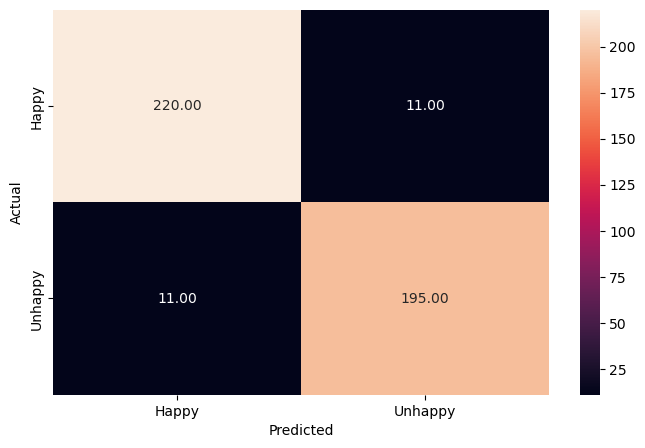

Training Score: 1.0
Testing Score: 0.9496567505720824

Feature Importance
-------------------------------------
freedom_to_make_life_choices: (0.24251290534532197)
life_ladder_log: (0.20483266264324282)
positive_affect: (0.14508342574497196)
social_support: (0.07900220135714223)
confidence_in_national_government: (0.07289157380878093)
gdp_per_capita: (0.07105706768291409)
healthy_life_expectancy_at_birth: (0.06904872156304193)
generosity: (0.06227463946810166)
perceptions_of_corruption: (0.031167289799287817)
negative_affect: (0.022129512587194696)


In [64]:
metrics_score(y_test, y_pred)

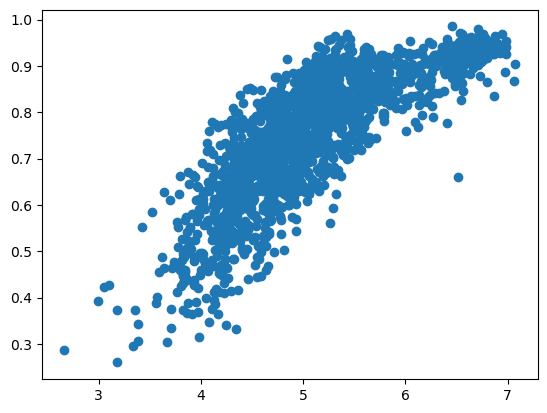

In [31]:
plt.scatter(happiness_df['happiness_score'], X['freedom_to_make_life_choices'])

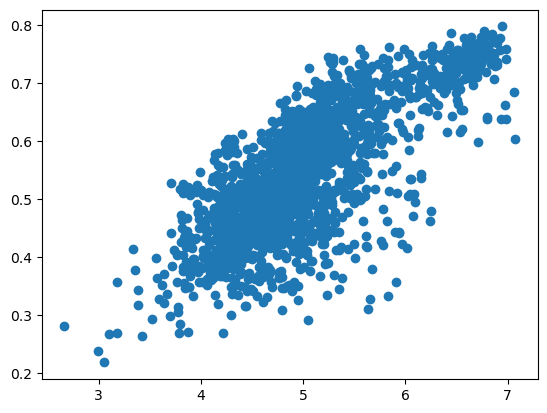

In [32]:
plt.scatter(happiness_df['happiness_score'], X['life_ladder_log'])

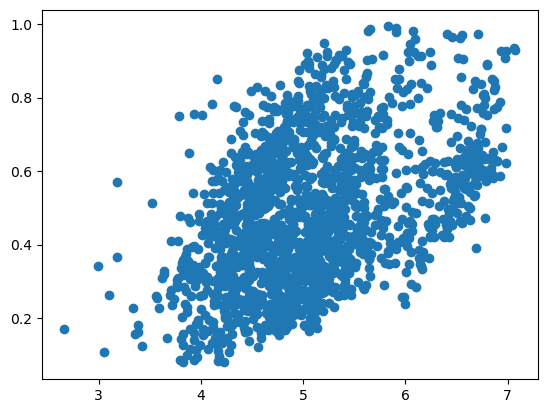

In [33]:
plt.scatter(happiness_df['happiness_score'], X['confidence_in_national_government'])